In [13]:
## Import standard libraries
from scipy import signal, stats
import numpy as np
from numpy.fft import irfft
import csv
import pandas as pd
import sys

## Import plotting library
import matplotlib.pyplot as plt

## Import own libraries
sys.path.insert(1, r"E:\ReverberationRoom\standards\standards") # Rob PC
sys.path.insert(1, r"E:\ReverberationRoom\reverb-tkinter-interface") # Rob PC

import filterAndBands
import helpers
import iso354

print('Successfully loaded all packages')

Successfully loaded all packages


In [14]:
# Load and inspect config data
config_data = helpers.parseConfigFile(path=r'E:\ReverberationRoom\reverb-tkinter-interface\config.cfg') # Rob PC

# Read all configuration data
fs = int(config_data['samplingfrequency'])  # Sampling frequency
print('Sampling frequency (Hz): {}'.format(fs))
rise_time = float(config_data['risetime'])  # Rise time for excitation
print('Rise time (s): {}'.format(rise_time))
excitation_time = float(config_data['excitationtime'])  # Duration that excitation is played for
print('Excitation time (s): {}'.format(excitation_time))
mics = config_data['micid'] # IDs for microphones as listed in NI-MAX
print('Mic NI-MAX ids: {}'.format(mics))
channel_name = config_data['micnames']  # Microphone names
print('Mic names: {}'.format(channel_name))
analog_output_id = config_data['outputid']  # IDs for outputs as listed in NI-MAX
print('Analog outut ids: {}'.format(analog_output_id))
estRT = float(config_data['estimatedrt'])   # Estimated reverberation time for room - allows selection of filtering time
print('Estimated RT (s): {}'.format(estRT))
pRef = float(config_data['referencepressure'])  # Reference pressure value for conversion to dB
print('Reference pressure (Pa): {}'.format(pRef))
p_ref = pRef
n_mics = int(config_data['nummics'])    # Number of microphones used in measurements
print('Number of mics in measurements: {}'.format(n_mics))
window_length = float(config_data['windowlength'])  # Desired length of window
print('Length of averaging window (s): {}'.format(window_length))
fLow = int(config_data['flow'])     # Low frequency limit for 1/3rd octave bands
print('Low frequency (Hz): {}'.format(fLow))
fHigh = int(config_data['fhigh'])   # High frequency limit for 1/3rd octave bands
print('High frequency (Hz): {}'.format(fHigh))
averaging_type = config_data['avgtype'] # Select exponential or linear averaging
print('Average type: {}'.format(averaging_type))
signal_type = config_data['usestoredexcitation']    # If a pre-calculated excitation signal was used in measurements
print('Signal type: {}'.format(signal_type))

Sampling frequency (Hz): 50000
Rise time (s): 1.0
Excitation time (s): 5.0
Mic NI-MAX ids: ['ai0', 'ai1', 'ai2', 'ai3', 'ai4', 'ai5']
Mic names: ['mic01', 'mic02', 'mic03', 'mic04', 'mic05', 'mic06']
Analog outut ids: ['ao0', 'ao1']
Estimated RT (s): 2.0
Reference pressure (Pa): 2e-05
Number of mics in measurements: 6
Length of averaging window (s): 0.25
Low frequency (Hz): 100
High frequency (Hz): 5000
Average type: exp
Signal type: true


Shape of data file: (1, 6, 700000)
[-0.05294679 -0.01215977  0.04711229 ...  0.1161994   0.11614487
  0.11704458]


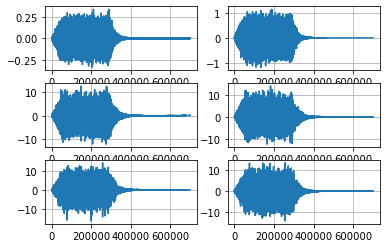

In [21]:
## Import verification data
data = np.load('withFabric.npy')
print('Shape of data file: {}'.format(np.shape(data)))
print(data[0][1])
t = np.arange(max(np.shape(data)))

fig, axs = plt.subplots(3, 2)
axs[0,0].plot(t, data[0][0])
axs[0,0].grid(True)
axs[1,0].plot(t, data[0][1])
axs[1,0].grid(True)
axs[2,0].plot(t, data[0][2])
axs[2,0].grid(True)
axs[0,1].plot(t, data[0][3])
axs[0,1].grid(True)
axs[1,1].plot(t, data[0][4])
axs[1,1].grid(True)
axs[2,1].plot(t, data[0][5])
axs[2,1].grid(True)

plt.show()

Shape of averaged data: (6, 700000)


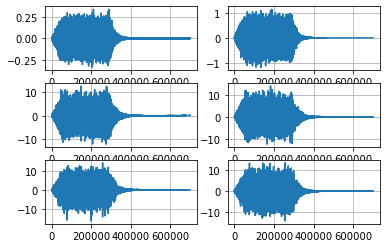

In [24]:
# Perform ensemble averaging 
mean_data = np.mean(a=data, axis=0)
print('Shape of averaged data: {}'.format(np.shape(mean_data)))

fig, axs = plt.subplots(3, 2)
axs[0,0].plot(t, mean_data[0])
axs[0,0].grid(True)
axs[1,0].plot(t, mean_data[1])
axs[1,0].grid(True)
axs[2,0].plot(t, mean_data[2])
axs[2,0].grid(True)
axs[0,1].plot(t, mean_data[3])
axs[0,1].grid(True)
axs[1,1].plot(t, mean_data[4])
axs[1,1].grid(True)
axs[2,1].plot(t, mean_data[5])
axs[2,1].grid(True)

plt.show()

In [25]:
# Build pandas df for data
print('Inserting data into pandas dataFrame')
df = pd.DataFrame()
rt_df = pd.DataFrame(columns=['frequency_Hz']+mics)
for row, mic in zip(mean_data, mics):
    print('Inserted mic: {}'.format(mic))
    df['mean_{}'.format(mic)] = row
print(df)

Inserting data into pandas dataFrame
Inserted mic: ai0
Inserted mic: ai1
Inserted mic: ai2
Inserted mic: ai3
Inserted mic: ai4
Inserted mic: ai5
        mean_ai0  mean_ai1  mean_ai2  mean_ai3  mean_ai4  mean_ai5
0      -0.003217 -0.052947  0.235262 -0.037952  0.041060  0.419703
1      -0.000382 -0.012160  0.260235 -0.042123  0.076557  0.413269
2       0.003653  0.047112  0.291453 -0.038933  0.108538  0.408661
3       0.005180  0.087245  0.312473 -0.032172  0.125496  0.389740
4       0.005344  0.093352  0.320707 -0.020912  0.129313  0.356368
...          ...       ...       ...       ...       ...       ...
699995  0.000573  0.116608  0.089372 -0.001472  0.082228  0.108211
699996  0.001827  0.117126  0.091035 -0.001854  0.081656  0.109029
699997  0.001827  0.116199  0.089617 -0.002072  0.081956  0.109901
699998  0.000900  0.116145  0.089671 -0.001418  0.082201  0.108347
699999  0.001254  0.117045  0.089235 -0.000872  0.081874  0.108538

[700000 rows x 6 columns]


{100: array([-2.91404043e-20, -3.52789277e-19, -2.10185049e-18, ...,
        3.61960938e-05,  3.70939183e-05,  3.79861745e-05]), 125: array([-1.16918982e-19, -1.41508134e-18, -8.42784559e-18, ...,
       -5.24690179e-05, -5.29819473e-05, -5.34794532e-05]), 160: array([-5.03344984e-19, -6.08960600e-18, -3.62502669e-17, ...,
       -1.59451251e-05, -1.51577601e-05, -1.43644045e-05]), 200: array([-1.85462483e-18, -2.24271235e-17, -1.33425904e-16, ...,
        5.83284679e-05,  5.77914814e-05,  5.72164374e-05]), 250: array([-7.43046754e-18, -8.97942891e-17, -5.33777787e-16, ...,
       -1.07969210e-05, -1.25385889e-05, -1.42670572e-05]), 315: array([-2.94313781e-17, -3.55350471e-16, -2.11000666e-15, ...,
       -3.83198461e-05, -3.56530486e-05, -3.29341528e-05]), 400: array([-1.17383737e-16, -1.41552152e-15, -8.39194509e-15, ...,
       -1.22602857e-05, -1.20053452e-05, -1.17170838e-05]), 500: array([-4.68938197e-16, -5.64544750e-15, -3.33979917e-14, ...,
       -7.77339966e-05, -7.00904933

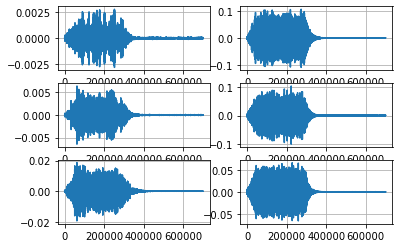

In [35]:
# Calculate RT for mic 1
mic=mics[0]
filtered_data = filterAndBands.thirdOctFilters(data=df['mean_{}'.format(mic)], fs=fs, f_low=fLow, f_high=fHigh)
print(filtered_data)
# print(filtered_data)
print('Shape of 100Hz filtered data for mic 0: {}'.format(np.shape(filtered_data[100])))

fig, axs = plt.subplots(3, 2)
axs[0,0].plot(t, filtered_data[100])
axs[0,0].grid(True)
axs[1,0].plot(t, filtered_data[125])
axs[1,0].grid(True)
axs[2,0].plot(t, filtered_data[160])
axs[2,0].grid(True)
axs[0,1].plot(t, filtered_data[2000])
axs[0,1].grid(True)
axs[1,1].plot(t, filtered_data[2500])
axs[1,1].grid(True)
axs[2,1].plot(t, filtered_data[3150])
axs[2,1].grid(True)
plt.show()

Empty RT DF
Dataframe with SPL filtered data
        mean_ai0  mean_ai1  mean_ai2  mean_ai3  mean_ai4  mean_ai5  \
0      -0.003217 -0.052947  0.235262 -0.037952  0.041060  0.419703   
1      -0.000382 -0.012160  0.260235 -0.042123  0.076557  0.413269   
2       0.003653  0.047112  0.291453 -0.038933  0.108538  0.408661   
3       0.005180  0.087245  0.312473 -0.032172  0.125496  0.389740   
4       0.005344  0.093352  0.320707 -0.020912  0.129313  0.356368   
...          ...       ...       ...       ...       ...       ...   
699995  0.000573  0.116608  0.089372 -0.001472  0.082228  0.108211   
699996  0.001827  0.117126  0.091035 -0.001854  0.081656  0.109029   
699997  0.001827  0.116199  0.089617 -0.002072  0.081956  0.109901   
699998  0.000900  0.116145  0.089671 -0.001418  0.082201  0.108347   
699999  0.001254  0.117045  0.089235 -0.000872  0.081874  0.108538   

         ai0_100Hz   ai0_125Hz   ai0_160Hz   ai0_200Hz  ...   ai0_630Hz  \
0      -296.730688 -284.662899 -271.983

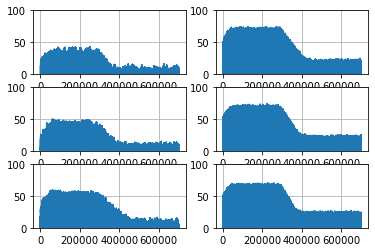

In [38]:
# Build DF for reverb results
rt_df['frequency_Hz'] = filtered_data.keys()
print('Empty RT DF')
# Get SPL in each 1/3rd octave band
for key in filtered_data:
    df['{}_{}Hz'.format(mic, key)] = 10*np.log10((abs(filtered_data[key])**2)/(p_ref**2))

print('Dataframe with SPL filtered data')
print(df)

fig, axs = plt.subplots(3, 2)
axs[0,0].plot(t, df['ai0_100Hz'])
axs[0,0].grid(True)
axs[0,0].set_ylim(0, 100)
axs[1,0].plot(t, df['ai0_125Hz'])
axs[1,0].grid(True)
axs[1,0].set_ylim(0, 100)
axs[2,0].plot(t, df['ai0_160Hz'])
axs[2,0].grid(True)
axs[2,0].set_ylim(0, 100)
axs[0,1].plot(t, df['ai0_2000Hz'])
axs[0,1].grid(True)
axs[0,1].set_ylim(0, 100)
axs[1,1].plot(t, df['ai0_2500Hz'])
axs[1,1].grid(True)
axs[1,1].set_ylim(0, 100)
axs[2,1].plot(t, df['ai0_3150Hz'])
axs[2,1].grid(True)
axs[2,1].set_ylim(0, 100)
plt.show()

df['{}_samples'.format(mic)] = np.arange(len(df['mean_{}'.format(mic)]))
df['{}_seconds'.format(mic)] = df['{}_samples'.format(mic)]/fs

mean_ai0  mean_ai1  mean_ai2  mean_ai3  mean_ai4  mean_ai5  \
0      -0.003217 -0.052947  0.235262 -0.037952  0.041060  0.419703   
1      -0.000382 -0.012160  0.260235 -0.042123  0.076557  0.413269   
2       0.003653  0.047112  0.291453 -0.038933  0.108538  0.408661   
3       0.005180  0.087245  0.312473 -0.032172  0.125496  0.389740   
4       0.005344  0.093352  0.320707 -0.020912  0.129313  0.356368   
...          ...       ...       ...       ...       ...       ...   
699995  0.000573  0.116608  0.089372 -0.001472  0.082228  0.108211   
699996  0.001827  0.117126  0.091035 -0.001854  0.081656  0.109029   
699997  0.001827  0.116199  0.089617 -0.002072  0.081956  0.109901   
699998  0.000900  0.116145  0.089671 -0.001418  0.082201  0.108347   
699999  0.001254  0.117045  0.089235 -0.000872  0.081874  0.108538   

         ai0_100Hz   ai0_125Hz   ai0_160Hz   ai0_200Hz  ...  ai0_630Hz_exp  \
0      -296.730688 -284.662899 -271.983285 -260.655479  ...    -200.673626   
1      -275

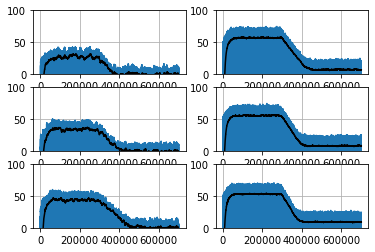

In [46]:
# Perform calculation on single 1/3rd octave band
key = 100
windowN = int(window_length*fs)   # Number of samples in window
for key in filtered_data:
    df['{}_{}Hz_exp'.format(mic, key)] = df['{}_{}Hz'.format(mic,key)].ewm(span=windowN, adjust=False).mean()
print(df)

fig, axs = plt.subplots(3, 2)
axs[0,0].plot(t, df['ai0_100Hz'])
axs[0,0].plot(t, df['ai0_100Hz_exp'], 'k')
axs[0,0].grid(True)
axs[0,0].set_ylim(0, 100)
axs[1,0].plot(t, df['ai0_125Hz'])
axs[1,0].plot(t, df['ai0_125Hz_exp'], 'k')
axs[1,0].grid(True)
axs[1,0].set_ylim(0, 100)
axs[2,0].plot(t, df['ai0_160Hz'])
axs[2,0].plot(t, df['ai0_160Hz_exp'], 'k')
axs[2,0].grid(True)
axs[2,0].set_ylim(0, 100)
axs[0,1].plot(t, df['ai0_2000Hz'])
axs[0,1].plot(t, df['ai0_2000Hz_exp'], 'k')
axs[0,1].grid(True)
axs[0,1].set_ylim(0, 100)
axs[1,1].plot(t, df['ai0_2500Hz'])
axs[1,1].plot(t, df['ai0_2500Hz_exp'], 'k')
axs[1,1].grid(True)
axs[1,1].set_ylim(0, 100)
axs[2,1].plot(t, df['ai0_3150Hz'])
axs[2,1].plot(t, df['ai0_3150Hz_exp'], 'k')
axs[2,1].grid(True)
axs[2,1].set_ylim(0, 100)
plt.show()


In [50]:
# Find excitation range
windowed_data = df['{}_{}Hz_{}'.format(mic, key, averaging_type)].values
excitation_range = [int((rise_time)*fs), int((rise_time+excitation_time)*fs)]
excitation_level = filterAndBands.dBavg(windowed_data[excitation_range[0]+int(0.5*fs):excitation_range[1]-int(0.5*fs)])
print('Excitation Level: {}'.format(excitation_level))
trigger_level = excitation_level - 5
print('Decay trigger level: {}'.format(trigger_level))
min_decay_level = min(windowed_data[excitation_range[1]:])
print('Minimum decay level: {}'.format(min_decay_level))
bg_start = len(windowed_data) - 2*fs
print('Start of bg evaluation - last 2 sec: {}'.format(bg_start))
bg_level = filterAndBands.dBavg(windowed_data[bg_start:])
print('Background noise level: {}'.format(bg_level))

Excitation Level: 47.80033974807192
Decay trigger level: 42.80033974807192
Minimum decay level: 10.128801184647166
Start of bg evaluation - last 2 sec: 600000
Background noise level: 10.791496329671117


In [52]:

ndx_start = np.where(windowed_data[excitation_range[1]:] <= trigger_level)
decay_start = ndx_start[0][0]
print('Start of evaluation range {} samples or {} seconds after excitation'.format(decay_start, decay_start/fs))

Start of evaluation range 4676 samples or 0.09352 seconds
